Lecture 6: Boundary Value Problems
===

Shooting Method
---
Example: We consider the BVP
$$
    u''(x) = \frac{3}{2} u^2(x), \qquad u(0) = 4, \quad u(1) = 1
$$

The Shooting Method converts this into an IVP,

$$
u''(x) = \frac{3}{2} u^2(x), \qquad u(0) = 4,\quad u'(0) = u_{guess}
$$

and the non-linear root-finding problem

$$
u(1; u_{guess}) - \underbrace{1}_{=u_{desired}(1)} = 0.
$$

Here, we use the Julia packages DifferentialEquations.jl and Roots.jl
to implement the shooting method for this problem.

In [1]:
using PyPlot
PyPlot.svg(true)

using DifferentialEquations
using Roots
using LinearAlgebra

In [2]:
function solve_ivp(u_guess; saveat=(0.0, 1.0))
    # Differential equation in first-order form
    f(u, p, t) = [u[2], 3.0/2.0 * u[1]^2]
    
    # initial conditions
    u0 = [4.0, u_guess]
    
    # time interval on which to solve
    tspan = (0.0, 1.0)
    
    prob = ODEProblem(f, u0, tspan)
    solution = solve(prob, saveat=saveat)
    
    # return u(1; u_guess)
    return solution
end

solve_ivp (generic function with 1 method)

In [10]:
solve_ivp(-8)

retcode: Success
Interpolation: 1st order linear
t: 2-element Array{Float64,1}:
 0.0
 1.0
u: 2-element Array{Array{Float64,1},1}:
 [4.0, -8.0]         
 [0.999984, -1.00005]

In [11]:
# define the root-finding problem
# solving this problem solves the BVP-- this is the shooting method
function root_finding_problem(u_guess)
    sln = solve_ivp(u_guess)
    u_1 = sln.u[end][1]
    u_1_desired = 1.0
    
    return u_1 - u_1_desired
end

root_finding_problem (generic function with 1 method)

In [17]:
root_finding_problem(-35.85775621541935)

-1.2878587085651816e-14

In [14]:
# Solve the root-finding problem using Roots.jl
# and the Bisection method (will revisit the details, for now this is a black box)

root = find_zero(root_finding_problem, (-10.0, 0.0), Bisection())

-7.9999927342830786

In [16]:
# Turns out there is a second solution!

root2 = find_zero(root_finding_problem, (-40.0, -30.0), Bisection())

-35.85775621541935

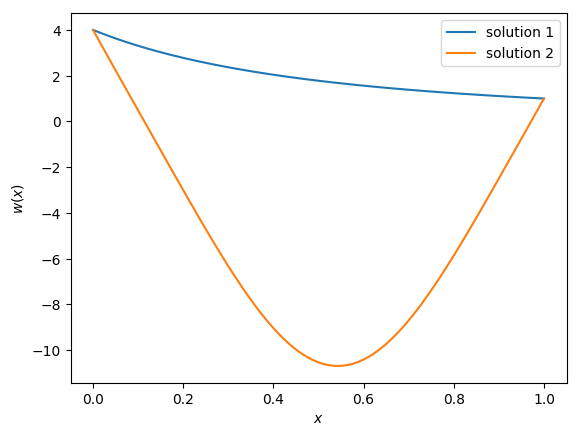

PyObject <matplotlib.legend.Legend object at 0x7f8c0de680b8>

In [19]:
# check the solution and plot it
solution_shooting = solve_ivp(root; saveat=LinRange(0, 1, 100))
solution_shooting2 = solve_ivp(root2; saveat=LinRange(0, 1, 100))


figure()
plot(solution_shooting.t, solution_shooting[1,:], label="solution 1")
plot(solution_shooting2.t, solution_shooting2[1,:], label="solution 2")

xlabel(L"x")
ylabel(L"w(x)")
legend()

Finite-Difference Method
---

The finite-difference method solves the BVP by sampling the solution interval
and converting the differential operator (and boundary conditions) into
a matrix equation.

Here, we consider the beam-bending example

$$
\alpha \frac{d^4 f}{dx^4} = q(x), \qquad q(x) = -x^2 \\
f(a) = f'(a) = f(b) = f'(b) = 0
$$

We discretize the solution interval into $N+1$ samples and define
$$
x_n = a + n h, \quad f_n = f(a + n h), \quad f^{(4)}_n = f^{(4)}(a + nh),
\quad q_n = q(a + nh), \qquad h = \frac{b - a}{N+1}.
$$

Then the finite-difference matrix implementing the fourth derivative
using a central-difference stencil of order 2 is the $(N+1)\times (N+1)$ matrix
$$
A = \frac{1}{h^4} \begin{pmatrix}
6 & -4 & 1 & 0 & \dots & & & & 0\\
-4 & 6 & -4 & 1 & 0 & \dots & & & 0 \\
1 & -4 & 6 & -4 & 1 & 0 & \dots & & 0 \\
0 & 1 & -4 & 6 & -4 & 1 & 0 & \dots & 0 \\
\vdots &  & \ddots & \ddots & \ddots & \ddots & \ddots &  & \vdots \\
0 & \dots & & & & 0 & -4 & 6 & -4 \\
0 & \dots & & & & 0 & 0 & -4 & 6 \\
\end{pmatrix}.
$$

The solution of the BVP is then given by
$$
\mathbf{f} = A^{-1} \left( \frac{1}{\alpha} \mathbf{q} \right),
$$
where $\mathbf{q}$ is the vector of beam loadings.

In [21]:
function fourth_derivative(N, h)
    # construct the matrix A implementing the fourth derivative
    A = diagm( 0 => 6*ones(N),
               1 => -4*ones(N-1),
              -1 => -4*ones(N-1), 
               2 => ones(N-2),
              -2 => ones(N-2))
    
    return A/h^4
end

fourth_derivative (generic function with 1 method)

In [22]:
# construct discretization and finite difference matrix
N = 100
a = 0.0
b = 10.0

h = (b - a)/(N+1)

A = fourth_derivative(N, h)

100×100 Array{Float64,2}:
  62436.2  -41624.2   10406.0       0.0  …       0.0       0.0       0.0
 -41624.2   62436.2  -41624.2   10406.0          0.0       0.0       0.0
  10406.0  -41624.2   62436.2  -41624.2          0.0       0.0       0.0
      0.0   10406.0  -41624.2   62436.2          0.0       0.0       0.0
      0.0       0.0   10406.0  -41624.2          0.0       0.0       0.0
      0.0       0.0       0.0   10406.0  …       0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0  …       0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      ⋮                  

In [33]:
# forcing vector
α = 1.0
x = zeros(N)
q = zeros(N)

for i=1:N
    x[i] = a + i*h
    q[i] = -sin(2π * x[i]/10)#x[i]/α
#     q[i] = -exp(-(x[i] - 5)^2/(2*4))
end

q

100-element Array{Float64,1}:
 -0.06216963743148053
 -0.12409875261325935
 -0.18554775382949326
 -0.24627890683200138
 -0.3060572545878873 
 -0.3646515262826552 
 -0.42183503206206224
 -0.4773865400511271 
 -0.531091132257275  
 -0.5827410360463008 
 -0.6321364279743265 
 -0.6790862068658859 
 -0.7234087331472497 
  ⋮                  
  0.6790862068658856 
  0.6321364279743258 
  0.5827410360463008 
  0.5310911322572747 
  0.47738654005112635
  0.4218350320620621 
  0.3646515262826547 
  0.30605725458788735
  0.24627890683200196
  0.18554775382949354
  0.12409875261325934
  0.06216963743148109

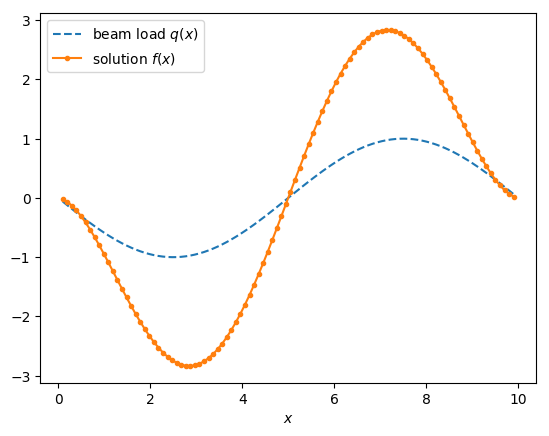

PyObject <matplotlib.legend.Legend object at 0x7f8c0d2f7080>

In [34]:
# solve the BVP. We will revisit the backslash operator later and understand what it really does internally
f = A \ q

figure()
plot(x, q, "--", label=L"beam load $q(x)$")
plot(x, f, ".-", label=L"solution $f(x)$")

xlabel(L"x")
legend()